In [1]:
import pandas as pd
import numpy as np
from data_providers import YahooMarketDataProvider
from datetime import datetime
import tensorflow as tf
from agent import TradingAgent
from gym_trading_env.environments import TradingEnv
import gymnasium as gym
from tqdm import tqdm
import gym_trading_env
import mlflow
import warnings
import sys
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
data_provider = YahooMarketDataProvider()

In [3]:
stocks_to_test = ["TSLA", "AAPL"]
currencies_to_test = ["THBEUR=X", "EURUSD=X"]
cryptos_to_test = ["BTC-USD", "ETH-USD"]
stock_indices_to_test = ["^GSPC", "^DJI"] # dow jones and S&P500

assets_to_test = stocks_to_test + currencies_to_test+ cryptos_to_test+ stock_indices_to_test

df_dict = {asset: None for asset in assets_to_test}
comparison_dict = {asset: {'model_values':[],'buy_and_hold_values':[], 'date':[]} for asset in assets_to_test}


In [4]:
for ticker in df_dict.keys():
    data = data_provider.get_data(ticker,'1h', from_date='2022-01-01', to_date='2022-12-31')
    df_dict[ticker] = data
    print(f"Data downloaded for ticker {ticker}")


Data downloaded for ticker TSLA
Data downloaded for ticker AAPL
Data downloaded for ticker THBEUR=X
Data downloaded for ticker EURUSD=X
Data downloaded for ticker BTC-USD
Data downloaded for ticker ETH-USD
Data downloaded for ticker ^GSPC
Data downloaded for ticker ^DJI


In [5]:
#training episode to use weights of 
episode_checkpoint = 330
#initial starting capital
starting_capital = 10000
# max steps per episode
max_episode_steps=100
# total episodes
max_episodes = 100
# discount factor
gamma = .99
# update frequency between online model and target model
tau =100
# Adam learning rate
learning_rate=0.0001
 # L2 regularization using norm 2 euclidian distance
l2_reg = 1e-6
# size of the prioritized replay buffer
replay_capacity = int(1e5)
# batch size to fetch from replay buffer
batch_size=4096
# epsilon greedy policy parameters
epsilon_start = 1.0
epsilon_end = .01
epsilon_decay_episodes = 0.8* max_episodes
epsilon_exponential_decay = .99
actions = [-0.5-0.1,0,0.1,0.5]

tf.keras.backend.clear_session()

def reward_function(history):
    return 800*np.log(history["portfolio_valuation", -1] / history["portfolio_valuation", -2]) #log (p_t / p_t-1 )

number_of_features = 16
window_size = 15
state_dimensions = 95

checkpoint_file_path = "checkpoints/episode-{episode:04d}/checkpoint"

trading_agent = TradingAgent(
                num_actions=4,
                learning_rate=learning_rate,
                gamma=gamma,
                epsilon_start=epsilon_start,
                epsilon_end=epsilon_end,
                epsilon_decay_episodes=epsilon_decay_episodes,
                epsilon_exponential_decay=epsilon_exponential_decay,
                replay_capacity=replay_capacity,
                l2_reg=l2_reg,
                tau=tau,
                batch_size=batch_size,
                window_size=window_size,
                number_of_features=number_of_features,
                weights_path=checkpoint_file_path.format(episode=episode_checkpoint))

In [6]:
for ticker, df in tqdm(df_dict.items()):
    env = gym.make(
    "TradingEnv",
    name= "BTCUSD",
    df = df,
    windows= window_size,
    positions = actions,
    initial_position = 0, #Initial position
    trading_fees = 0.01/100, # 0.01% per stock buy / sell
    borrow_interest_rate= 0.0003/100, #per timestep (= 1h here)
    reward_function = reward_function,
    portfolio_initial_value = starting_capital, # in FIAT (here, USD)
    verbose=1,
    )
    
    # Run model episode
    done, truncated = False, False
    this_state = np.reshape(env.reset()[0],(window_size, number_of_features))
    while not done and not truncated:
        action_index = trading_agent.predict(this_state)
        next_state, reward, done, truncated, info = env.step(action_index)
        next_state = np.reshape(next_state,(window_size, number_of_features))
        this_state = next_state
        comparison_dict[ticker]["model_values"].append(env.unwrapped.historical_info["portfolio_valuation"][-1])
        comparison_dict[ticker]["date"].append(env.unwrapped.historical_info["data_date_close"][-1])

    # Run buy and hold

    done, truncated = False, False
    this_state = np.reshape(env.reset()[0],(window_size, number_of_features))
    while not done and not truncated:
        action_index = actions.index(0.1)
        next_state, reward, done, truncated, info = env.step(action_index)
        next_state = np.reshape(next_state,(window_size, number_of_features))
        this_state = next_state
        comparison_dict[ticker]["buy_and_hold_values"].append(env.unwrapped.historical_info["portfolio_valuation"][-1])


 12%|█▎        | 1/8 [04:09<29:08, 249.75s/it]

Market Return : -65.24%   |   Portfolio Return :  2.91%   |   
Market Return : -65.24%   |   Portfolio Return : -6.53%   |   


 25%|██▌       | 2/8 [08:03<24:00, 240.05s/it]

Market Return : -24.54%   |   Portfolio Return :  2.83%   |   
Market Return : -24.54%   |   Portfolio Return : -2.45%   |   
Market Return :  1.28%   |   Portfolio Return : -5.60%   |   


 38%|███▊      | 3/8 [19:07<36:09, 433.81s/it]

Market Return :  1.28%   |   Portfolio Return :  0.13%   |   
Market Return : -5.10%   |   Portfolio Return : -8.62%   |   


 50%|█████     | 4/8 [41:01<52:05, 781.48s/it]

Market Return : -5.10%   |   Portfolio Return : -0.51%   |   
Market Return : -64.68%   |   Portfolio Return : -37.50%   |   


 62%|██████▎   | 5/8 [1:01:31<47:09, 943.22s/it]

Market Return : -64.68%   |   Portfolio Return : -6.47%   |   
Market Return : -68.37%   |   Portfolio Return : -19.57%   |   


 75%|███████▌  | 6/8 [1:17:14<31:25, 942.92s/it]

Market Return : -68.37%   |   Portfolio Return : -6.84%   |   


 88%|████████▊ | 7/8 [1:20:26<11:37, 697.52s/it]

Market Return : -17.53%   |   Portfolio Return : -13.14%   |   
Market Return : -17.53%   |   Portfolio Return : -1.75%   |   


100%|██████████| 8/8 [1:23:40<00:00, 627.59s/it]

Market Return : -7.61%   |   Portfolio Return : -13.46%   |   
Market Return : -7.61%   |   Portfolio Return : -0.76%   |   


In [7]:
print(len(comparison_dict["TSLA"]["model_values"]))
print(len( comparison_dict["TSLA"]["buy_and_hold_values"]))

1710
1710


In [8]:
stocks_to_test = ["TSLA", "AAPL"]
currencies_to_test = ["THBEUR=X", "EURUSD=X"]
cryptos_to_test = ["BTC-USD", "ETH-USD"]
stock_indices_to_test = ["^GSPC", "^DJI"] # dow jones and S&P500

tesla_portfolio_df = pd.DataFrame({'TSLA_model': comparison_dict["TSLA"]["model_values"], 'TSLA_buy_and_hold': comparison_dict["TSLA"]["buy_and_hold_values"], "date": comparison_dict["TSLA"]["date"]})
aapl_portfolio_df = pd.DataFrame({'AAPL_model': comparison_dict["AAPL"]["model_values"], 'AAPL_buy_and_hold': comparison_dict["AAPL"]["buy_and_hold_values"], "date": comparison_dict["AAPL"]["date"]})

thbeur_portfolio_df = pd.DataFrame({'THB_EUR_model': comparison_dict["THBEUR=X"]["model_values"], 'THB_EUR_buy_and_hold': comparison_dict["THBEUR=X"]["buy_and_hold_values"], "date": comparison_dict["THBEUR=X"]["date"]})
eurusd_portfolio_df = pd.DataFrame({'EUR_USD_model': comparison_dict["EURUSD=X"]["model_values"], 'EUR_USD_buy_and_hold': comparison_dict["EURUSD=X"]["buy_and_hold_values"], "date": comparison_dict["EURUSD=X"]["date"]})

btcusd_portfolio_df = pd.DataFrame({'BTC_USD_model': comparison_dict["BTC-USD"]["model_values"], 'BTC_USD_buy_and_hold': comparison_dict["BTC-USD"]["buy_and_hold_values"], "date": comparison_dict["BTC-USD"]["date"]})
ethusd_portfolio_df = pd.DataFrame({'ETH_USD_model': comparison_dict["ETH-USD"]["model_values"], 'ETH_USD_buy_and_hold': comparison_dict["ETH-USD"]["buy_and_hold_values"], "date": comparison_dict["ETH-USD"]["date"]})

gspc_portfolio_df = pd.DataFrame({'SP500_model': comparison_dict["^GSPC"]["model_values"], 'SP500_buy_and_hold': comparison_dict["^GSPC"]["buy_and_hold_values"], "date": comparison_dict["^GSPC"]["date"]})
dji_portfolio_df = pd.DataFrame({'DOW_JONES_model': comparison_dict["^DJI"]["model_values"], 'DOW_JONES_buy_and_hold': comparison_dict["^DJI"]["buy_and_hold_values"], "date": comparison_dict["^DJI"]["date"]})

In [9]:
import matplotlib.pyplot as plt

In [18]:
plot_dict = {}
plot_dict["keys"] = list(comparison_dict.keys())
plot_dict["model_values"] = []
plot_dict["buy_and_hold_values"] = []
for key, test in comparison_dict.items():
    plot_dict["model_values"].append((comparison_dict[key]["model_values"][-1]-10000) / 10000)
    plot_dict["buy_and_hold_values"].append((comparison_dict[key]["buy_and_hold_values"][-1]-10000) / 10000)
    

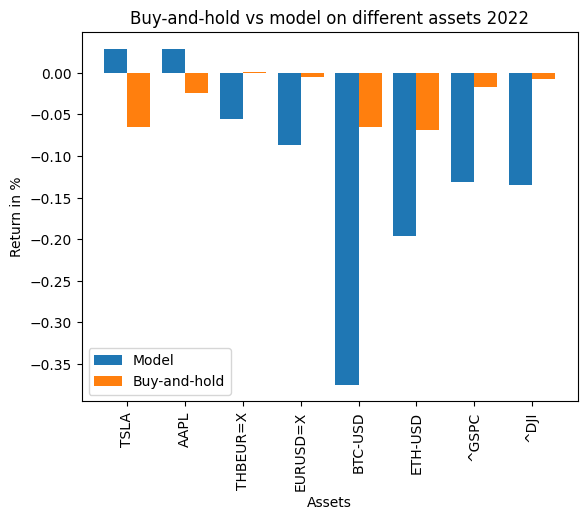

In [31]:
x_axis = np.arange(len(plot_dict["keys"]))

plt.bar(x_axis -0.2, plot_dict["model_values"], width=0.4, label = 'Model')
plt.bar(x_axis +0.2, plot_dict["buy_and_hold_values"], width=0.4, label = 'Buy-and-hold')
plt.xticks(x_axis, plot_dict["keys"], rotation=90)
plt.xlabel("Assets")
plt.ylabel("Return in %")
plt.title("Buy-and-hold vs model on different assets 2022")
plt.legend()
plt.show()


<Axes: >

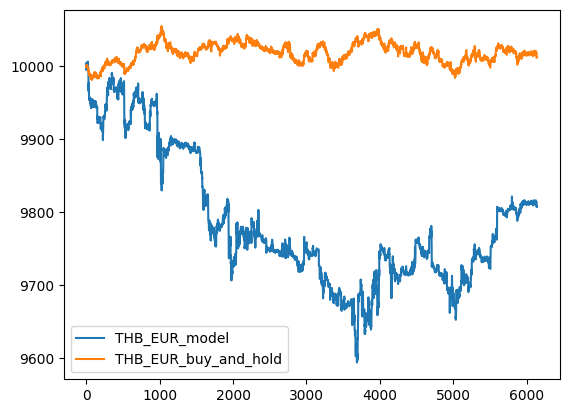

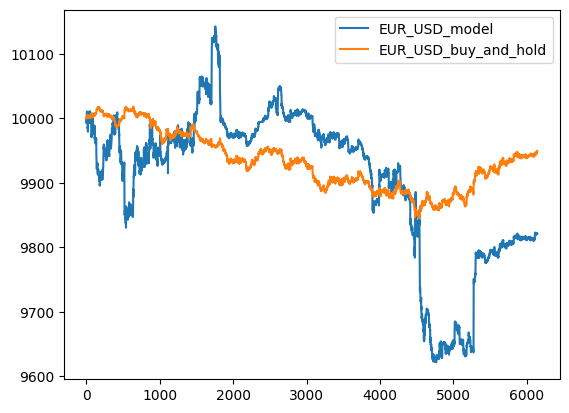

In [16]:
thbeur_portfolio_df.plot.line()
eurusd_portfolio_df.plot.line()

<Axes: >

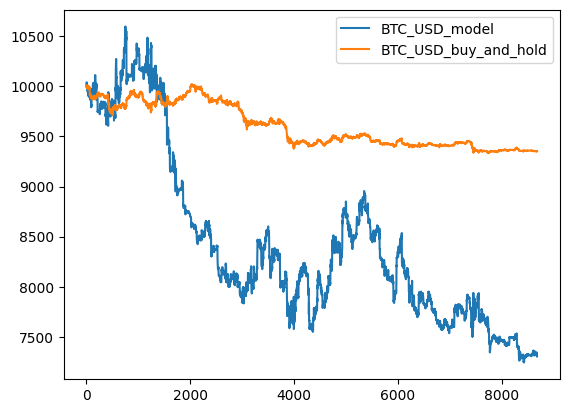

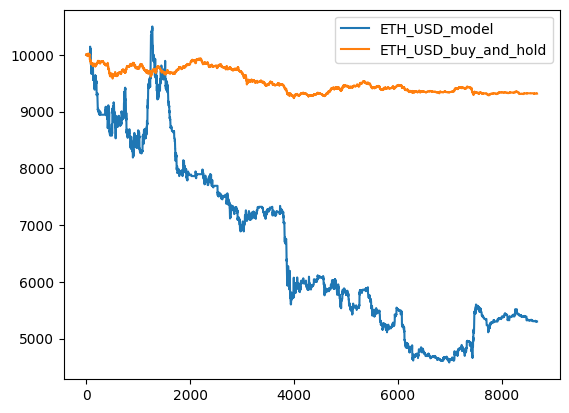

In [17]:
btcusd_portfolio_df.plot.line()
ethusd_portfolio_df.plot.line()

<Axes: >

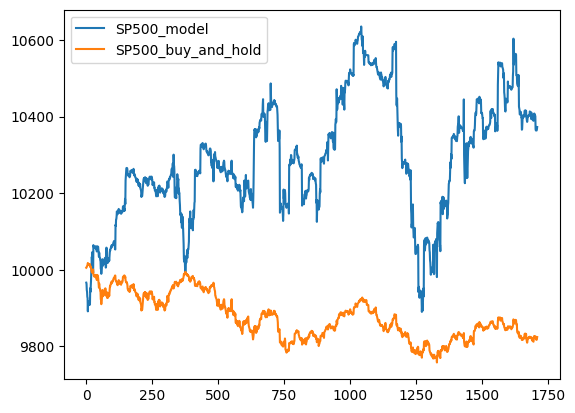

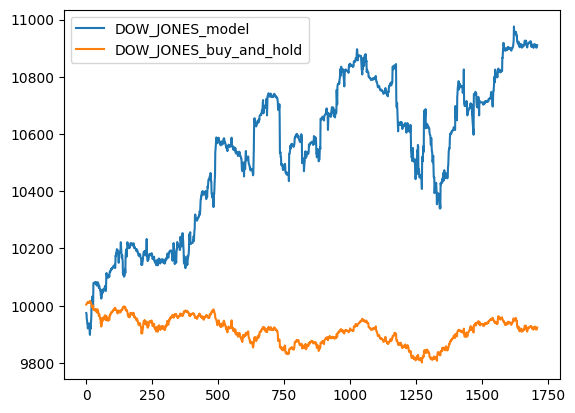

In [18]:
gspc_portfolio_df.plot.line()
dji_portfolio_df.plot.line()